<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Access" data-toc-modified-id="Data-Access-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Access</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Read" data-toc-modified-id="Read-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read</a></span></li><li><span><a href="#Coordinates-and-Solar-Zenith-Angles" data-toc-modified-id="Coordinates-and-Solar-Zenith-Angles-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Coordinates and Solar Zenith Angles</a></span><ul class="toc-item"><li><span><a href="#Define-SRS" data-toc-modified-id="Define-SRS-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Define SRS</a></span></li><li><span><a href="#Permute-x-and-y" data-toc-modified-id="Permute-x-and-y-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Permute x and y</a></span></li><li><span><a href="#Flatten-and-transform" data-toc-modified-id="Flatten-and-transform-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Flatten and transform</a></span></li><li><span><a href="#Add-coordinates" data-toc-modified-id="Add-coordinates-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Add coordinates</a></span></li><li><span><a href="#Solar-zenith-angle" data-toc-modified-id="Solar-zenith-angle-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Solar zenith angle</a></span></li></ul></li><li><span><a href="#Quality-flags" data-toc-modified-id="Quality-flags-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Quality flags</a></span></li><li><span><a href="#Albedo" data-toc-modified-id="Albedo-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Albedo</a></span><ul class="toc-item"><li><span><a href="#Black-sky-albedo" data-toc-modified-id="Black-sky-albedo-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Black sky albedo</a></span></li><li><span><a href="#White-sky-albedo" data-toc-modified-id="White-sky-albedo-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>White sky albedo</a></span></li><li><span><a href="#Blue-sky-albedo" data-toc-modified-id="Blue-sky-albedo-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Blue sky albedo</a></span></li></ul></li></ul></div>

# Workflow
This notebook documents the process for calculating the [black](#Black-sky-albedo), [white](#White-sky-albedo), and [blue](#Blue-sky-albedo) sky albedos from the MCD43A1 BRDF model parameters downloaded through LP DAAC's APPEEARS tool in netCDF format. 

## Data Access
[AppEEARS](https://lpdaacsvc.cr.usgs.gov/appeears) is web interface for requesting subsets from LP DAAC's data pool. The notebooks assume you used AppEEARS to get the subset. You need to sign up for a NASA Earthdata account. It was just convenient to have the subset come out in the shape of Florida like I wanted.

**To request a subset via the web UI**, [go to AppEEARS](https://lpdaacsvc.cr.usgs.gov/appeears), choose *Area Sample* from the *Extract* button in AppEEARS. Click *Start a new request*. 
1. Provide a name for your sample.
2. Choose a spatial extent by either uploading an ESRI Shapefile or GeoJSON, or by drawing a box/polygon on the map.
3. Choose a temporal extent for the subset.
4. Search for MCD43A1 under *Select the layers to include in the sample* and choose the C6 product: *MCD43A1.006*
5. Select the following layers:
    *   BRDF_Albedo_Parameters_Band\[`1-10`\]
    *   BRDF_Albedo_Parameters_vis
    *   BRDF_Albedo_Parameters_nir
    *   BRDF_Albedo_Parameters_shortwave    
    *   BRDF_Albedo_Band_Mandatory_Quality_Band\[`1-10`\]
    *   BRDF_Albedo_Band_Mandatory_Quality_vis
    *   BRDF_Albedo_Band_Mandatory_Quality_nir
    *   BRDF_Albedo_Band_Mandatory_Quality_shortwave
6. For *File Format*, choose *NetCDF*.
7. For *Projection*, choose *Sinusoidal*.

You can also modify the request json ([*MCD43A1-Florida-2018-request.json*](data/MCD43A1-Florida-2018-request.json)) and upload it to AppEEARS to order an identical subset to the one used in this notebook:
```json
{
  "error": null,
  "status": "processing",
  "created": "2019-06-21T17:00:02.310429",
  "task_id": "f9ecaf4c-4eee-4236-beee-50fcfeb50963",
  "updated": "2019-06-21T18:07:07.768944",
  "user_id": "jjmcnelis@outlook.com",
  "retry_at": null,
  "task_name": "MCD43A1_Florida_2018",
  "task_type": "area",
  "api_version": null,
  "svc_version": "2.23",
  "web_version": "2.23",
  "expires_on": "2019-07-21T18:07:07.768944",
  "attempts": 1
}
```

**To request a subset via the API**, do such and such...



**You will receive an email when your subset is ready.**

## Imports

In [1]:
## processing -->>
from pyproj import Proj, transform
from math import radians, cos
from io import StringIO
import xarray as xr   
import pandas as pd
import numpy as np
import datetime
import sys
import os

import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

Import `matplotlib` for plotting:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
matplotlib.rc('font', **{'size': 16})

## Read
Open the netCDF with `xarray`, rename x and y dimensions to cf standard, and print the header:

In [3]:
ds = xr.open_dataset("data/MCD43A1.2018.nc")
ds = ds.rename({"Num_Parameters": "param", "xdim": "x", "ydim": "y"})

ds

<xarray.Dataset>
Dimensions:                                       (param: 3, time: 365, x: 1336, y: 1555)
Coordinates:
  * time                                          (time) object 2018-01-01 00:00:00 ... 2018-12-31 00:00:00
  * y                                             (y) float64 3.447e+06 ... 2.727e+06
  * x                                             (x) float64 -8.404e+06 ... -7.785e+06
  * param                                         (param) int32 0 1 2
Data variables:
    crs                                           int8 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band1      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band2      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band3      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band4      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band5      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band6      (time, y, x) float32 ...
   

We'll test the code on a subset of the dataset. Select only the month of January:

In [4]:
ds = ds.isel(time=slice(0,31))
ds

<xarray.Dataset>
Dimensions:                                       (param: 3, time: 31, x: 1336, y: 1555)
Coordinates:
  * time                                          (time) object 2018-01-01 00:00:00 ... 2018-01-31 00:00:00
  * y                                             (y) float64 3.447e+06 ... 2.727e+06
  * x                                             (x) float64 -8.404e+06 ... -7.785e+06
  * param                                         (param) int32 0 1 2
Data variables:
    crs                                           int8 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band1      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band2      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band3      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band4      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band5      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band6      (time, y, x) float32 ...
    

Notice the data are conveniently organized along three dimensions *time, x, y*.

## Coordinates and Solar Zenith Angles
Make a few more improvements to the structure of the dataset:
* Add two-dimensional arrays (2) of lat and lon values to improve spatial metadata
* Assign some additional metadata about the quality flags information to the *Mandatory_Quality* variables
* etc.

We need latitudes and longitudes to calculate the solar zenith angle, so use `numpy` and `proj` libraries to generate arrays of lat,lon equivalents for the *x, y* coordinates in the dataset. A few steps are required:

### Define SRS
Define spatial information for the source x,y arrays and the target lon,lat arrays using `pyproj.Proj`

In [5]:
ds.crs

<xarray.DataArray 'crs' ()>
array(-127, dtype=int8)
Attributes:
    grid_mapping_name:                      sinusoidal
    _CoordinateAxisTypes:                   GeoX GeoY
    semi_major_axis:                        6371007.181
    semi_minor_axis:                        6371007.181
    longitude_of_central_meridian:          0
    longitude_of_projection_origin:         0
    straight_vertical_longitude_from_pole:  0
    false_easting:                          0
    false_northing:                         0

I'm not aware of any geoscience application where sinusoidal coordinates are reference to an origin other than lat==0, lon==0. So, this piece is unnecessary, but it stays for the sake of provenance.

I only used the lambda `getpar` to avoid having too many columns. The mess below is assembling the attributes from `ds.crs` into the proj4 string to be consumed by `pyproj.Proj`. Use the EPSG code for WGS84:

In [6]:
getpar = lambda a: str(ds.crs.attrs[a])

inproj = Proj(" ".join([
    "+proj=sinu",
    "+lon_0="+getpar("longitude_of_central_meridian"),
    "+x_0="+getpar("false_easting"),
    "+y_0="+getpar("false_northing"),
    "+a="+getpar("semi_major_axis"),
    "+b="+getpar("semi_minor_axis"),
    "+units="+"meter +no_defs"]))

outproj = Proj(init="epsg:4326")

inproj

pyproj.Proj('+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs ', preserve_units=True)

### Permute x and y
After we expand **x** and **y** to two dimensions, we need immediately flatten them so when they're taken together they represent a sequence of latitude longitude pairs that enumerate over all pixels from top-left to bottom-right of the dataset. 

You can do this with `numpy.meshgrid` then `numpy.array.flatten`. Use `numpy.meshgrid` first:

In [7]:
xx, yy = np.meshgrid(ds.x.data, ds.y.data)

xx

array([[-8403797.7087391 , -8403334.39602257, -8402871.08330604, ...,
        -7786201.85760757, -7785738.54489104, -7785275.23217452],
       [-8403797.7087391 , -8403334.39602257, -8402871.08330604, ...,
        -7786201.85760757, -7785738.54489104, -7785275.23217452],
       [-8403797.7087391 , -8403334.39602257, -8402871.08330604, ...,
        -7786201.85760757, -7785738.54489104, -7785275.23217452],
       ...,
       [-8403797.7087391 , -8403334.39602257, -8402871.08330604, ...,
        -7786201.85760757, -7785738.54489104, -7785275.23217452],
       [-8403797.7087391 , -8403334.39602257, -8402871.08330604, ...,
        -7786201.85760757, -7785738.54489104, -7785275.23217452],
       [-8403797.7087391 , -8403334.39602257, -8402871.08330604, ...,
        -7786201.85760757, -7785738.54489104, -7785275.23217452]])

### Flatten and transform
Flatten and transform the expanded 2d arrays and pass them as arguments 3 and 4 to `pyproj.transform` to get lon,lat pairs:

In [8]:
lon1d, lat1d = transform(
    inproj, 
    outproj, 
    xx.flatten(), 
    yy.flatten())

print("First five (lon,lat) pairs:"); list(zip(lon1d[:5], lat1d[:5]))

First five (lon,lat) pairs:


[(-88.17267591715559, 31.002083330549265),
 (-88.16781483846015, 31.002083330549265),
 (-88.16295375976472, 31.002083330549265),
 (-88.15809268106929, 31.002083330549265),
 (-88.15323160237384, 31.002083330549265)]

Reshape the new lon,lat arrays to match the original shape of the 2d x (`xx`) and y (`yy`) arrays. The **latitude** and **longitude** variables in the final dataset will be arranged along the **x** and **y** dimensions (both are 1d), so that every sinusoidal pixel is assigned a geographic reference.

Plot all of the two-dimensional coordinate arrays:

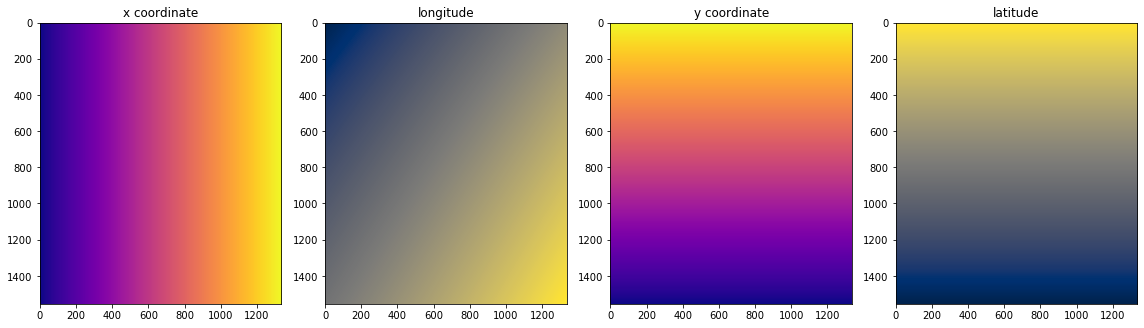

In [9]:
lon2d, lat2d = lon1d.reshape(xx.shape), lat1d.reshape(yy.shape)

# plot
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(1,4,1)
ax1.imshow(xx, cmap=cm.plasma); 
ax1.set_title("x coordinate")

ax2 = fig.add_subplot(1,4,2, sharey=ax1)
ax2.imshow(lon2d, cmap=cm.cividis); 
ax2.set_title("longitude")

ax3 = fig.add_subplot(1,4,3, sharey=ax1)
ax3.imshow(yy, cmap=cm.plasma); 
ax3.set_title("y coordinate")

ax4 = fig.add_subplot(1,4,4, sharey=ax1)
ax4.imshow(lat2d, cmap=cm.cividis); 
ax4.set_title("latitude")

fig.tight_layout()

### Add coordinates
Now we can add them to our dataset add two additional coordinate variables by creating an `xr.DataArray` for each and adding them to the dataset. This gets us closer to full compliance with CF recommendations:

In [10]:
ds.coords["lat"] = xr.DataArray(
    data=lat2d, 
    coords=[ds.y, ds.x], 
    dims=["y", "x"], 
    attrs=dict(
        standard_name="latitude",
        long_name="latitude coordinate",
        units="degrees_north"))

ds.coords["lon"] = xr.DataArray(
    data=lon2d, 
    coords=[ds.y, ds.x], 
    dims=["y", "x"], 
    attrs=dict(
        standard_name="longitude",
        long_name="longitude coordinate",
        units="degrees_east"))

ds.coords

Coordinates:
  * time     (time) object 2018-01-01 00:00:00 ... 2018-01-31 00:00:00
  * y        (y) float64 3.447e+06 3.447e+06 3.446e+06 ... 2.728e+06 2.727e+06
  * x        (x) float64 -8.404e+06 -8.403e+06 ... -7.786e+06 -7.785e+06
  * param    (param) int32 0 1 2
    lat      (y, x) float64 31.0 31.0 31.0 31.0 31.0 ... 24.53 24.53 24.53 24.53
    lon      (y, x) float64 -88.17 -88.17 -88.16 -88.16 ... -76.97 -76.96 -76.96

### Solar zenith angle
The only input to black- and white-sky albedos that doesn't come in MCD43A1 is the solar zenith angle (but, you can get it in MCD43A2 if you wish to use local solar noon). 

In this next cell, we import define the function that is implemented in [the first notebook](0_Terms_and_concepts.ipynb) and test it for the first pixel in our dataset:

In [11]:
def get_solar_zenith(doy, latitude, ndoy=365):
    """ """
    declination = cos(radians((doy+10)*(360/ndoy)))*-23.45
    altitude = 90 - latitude + declination
    zenith = 90 - altitude
    return(zenith)


sza = get_solar_zenith(ds.time[0].dt.dayofyear, ds.lat[0][0])
sza.name = "solar_zenith_angle"

sza

<xarray.DataArray 'solar_zenith_angle' ()>
array(54.032929)
Coordinates:
    y        float64 3.447e+06
    x        float64 -8.404e+06
    lat      float64 31.0
    lon      float64 -88.17

We also write a simple function to vectorize each calculation over our giant array. It should run significantly faster than a for loop. We can only vectorize over coordinates with matching dimensions, so we will have to loop over the timesteps.

```python
def vectorized(a, b):
    func = lambda x, y: np.sqrt(x ** 2 + y ** 2)
    return xr.apply_ufunc(func, a, b)
```

In [12]:
def sza_eval(doy, lat):
    """Convert CF to Python datetime."""
    func = lambda l: get_solar_zenith(doy, l)
    return(xr.apply_ufunc(func, lat))
    
# evaluate sza over all arrays using list comprehension 
sza_arr = np.dstack([sza_eval(t.dt.dayofyear, ds.lat) for t in ds.time])
sza_arr.shape

(1555, 1336, 31)

Make an `xarray.DataArray` for the solar zenith angles:

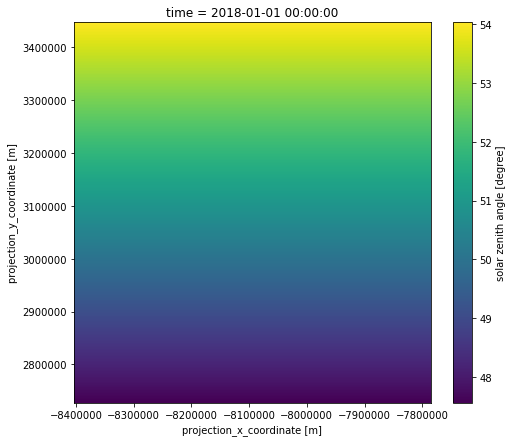

In [13]:
sza = xr.DataArray(
    data=sza_arr, 
    coords=[ds.y, ds.x, ds.time],
    dims=["y", "x", "time"],
    attrs=dict(
        units="degree",
        standard_name="solar zenith angle",
        long_name="solar zenith angle"))

sza = sza.transpose("time", "y", "x")
sza[0].plot(x="x", y="y", figsize=(8,7))

## Quality flags
We may decide to filter the pixels derived via magnitude BRDF inversions, but for now we will keep all data. They are already weighted to amplify the best observation over a 16 day period.

## Albedo

Now we can calculate the albedos. 

Three model parameters representing fiso, fvol, fgeo for the RossThickLiSparseReciprocal BRDF model that are computed for bands 1-7 and three broad bands: nir, shortwave, and vis.

MCD43A1 layers are named like:
```shell

BRDF_Albedo_Parameters-<BAND> ; BAND
    Band1, 
    Band2, 
    Band3, 
    Band4, 
    Band5, 
    Band6, 
    Band7, 
    nir, 
    shortwave, 
    vis
```

### Black sky albedo

See [0_Introduction.ipynb#Black-sky-albedo](0_Introduction.ipynb#Black-sky-albedo) for more information. The black sky albedo polynomial is computed as:

```shell   
                          K=iso       k=vol           k=geo
    G_0k(term 1)           1.0      -0.007574       -1.284909  
    G_1k(term SZN^2)       0.0      -0.070987       -0.166314  
    G_2k(term SZN^3)       0.0       0.307588        0.041840   
    
    BSA(SZN,BAND)=
        F_iso(BAND)*(G_0iso + G_1iso*SZN^2 + G_2iso*SZN^3) +
        F_vol(BAND)*(G_0vol + G_1vol*SZN^2 + G_2vol*SZN^3) +
        F_geo(BAND)*(G_0geo + G_1geo*SZN^2 + G_2geo*SNZ^3)

    SZN:  solar zenith angle
    BAND: band wavelength
    OD:   optical depth
    AMT:  aerosol model type
   
```
Define some functions that do the math above:

In [14]:
def fBSA(param1, param2, param3, sza):
    """ """
    s = np.radians(sza)
    func = lambda p1, p2, p3: (
        p1*( 1.0      +  0.0     *(s**2) + 0.0     *(s**3)) +  # Isotropic
        p2*(-0.007574 + -0.070987*(s**2) + 0.307588*(s**3)) +  # RossThick
        p3*(-1.284909 + -0.166314*(s**2) + 0.041840*(s**3)))   # LiSparseR
    return(xr.apply_ufunc(func, param1, param2, param3))


b1 = ds["BRDF_Albedo_Parameters_nir"]
param1 = b1.sel(param=0)
param2 = b1.sel(param=1)
param3 = b1.sel(param=2)
bsa = fBSA(param1, param2, param3, sza)

Add attributes to the black sky albedo array and plot:

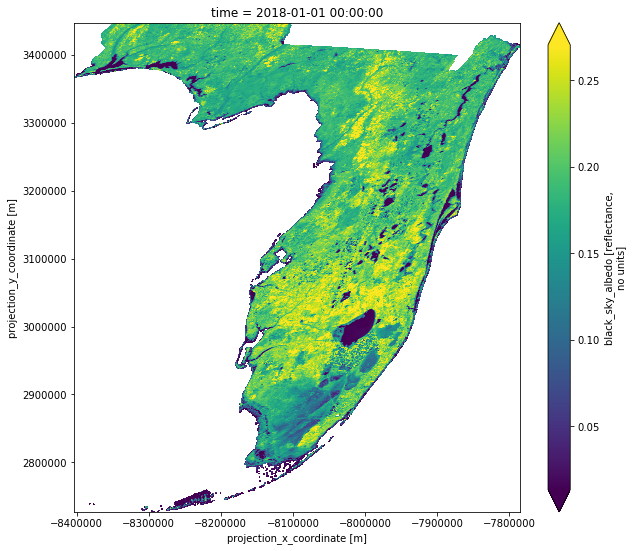

In [15]:
bsa.name = "black_sky_albedo"
bsa.attrs = dict(
    _FillValue=32767,
    coordinates="time y x",
    grid_mapping="crs",
    valid_min=0,
    valid_max=32766,
    long_name="black_sky_albedo",
    units="reflectance, no units",
    scale_factor_err=0.0,
    add_offset_err=0.0,
    calibrated_nt=5,
    scale_factor=0.001,
    add_offset=0.0)

bsa[0].plot.pcolormesh(x='x', y='y', robust=True, figsize=(10, 9),)

### White sky albedo

See [0_Introduction.ipynb#White-sky-albedo](0_Introduction.ipynb#White-sky-albedo) for more information. The black sky albedo polynomial is computed as follows:

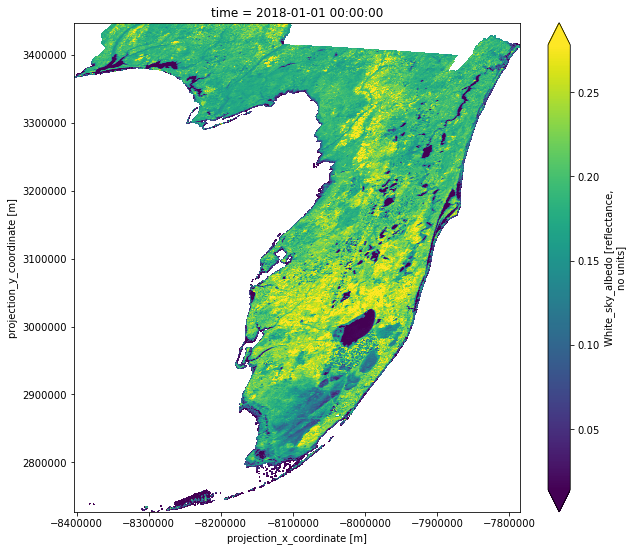

In [16]:
def fWSA(param1, param2, param3):
    """ """
    func = lambda p1, p2, p3: (
        p1* 1.0       +           # Isotropic
        p2* 0.189184  +           # RossThick
        p3*-1.377622 )            # LiSparseR  
    return(xr.apply_ufunc(func, param1, param2, param3))


wsa = fWSA(param1, param2, param3)
wsa.name = "White_sky_albedo"
wsa.attrs = dict(
    _FillValue=32767,
    coordinates="time y x",
    grid_mapping="crs",
    valid_min=0,
    valid_max=32766,
    long_name="White_sky_albedo",
    units="reflectance, no units",
    scale_factor_err=0.0,
    add_offset_err=0.0,
    calibrated_nt=5,
    scale_factor=0.001,
    add_offset=0.0)

wsa[0].plot.pcolormesh(x='x', y='y', robust=True, figsize=(10, 9),)

### Blue sky albedo 

The lookup values for each band are stored in tables in a text file ([*docs/actual_albedo_tool/albedo/skyl_lut.dat*](docs/actual_albedo_tool/albedo/skyl_lut.dat)). The values in the twenty tables are arranged such that the optical depth input (two-decimal places) selects the column and solar zenith angle input selects the row of the appropriate value. 

I cleaned up the table a little bit to make it easier to parse with `pandas`. The new file is at: [proc/skyl_lut.dat](proc/skyl_lut.dat).

Open the text file, parse it to a dictionary of tables numbered by band, and make a lookup function that returns the appropriate value:

In [17]:
with open("data/skyl_lut.dat", "r") as f:
    tab = f.read().replace("  ", " ")

con, mar = [t.split("Band") for t in tab.split("Aerosol_type: ")[1:]]
luts = {i+1: pd.read_csv(
    StringIO(b),
    index_col="S&O",
    skiprows=1,
    sep=" ") for i, b in enumerate(con[1:])}
   

def lookup(sza, luc):
    """ """    
    lfunc = lambda s: luc.iloc[s].values
    return(xr.apply_ufunc(lfunc, abs(sza).round(),))

Optical depth `sod` can be adjusted `0.00 to 0.98`:

In [18]:
sod = "0.20" # solar optical depth 
luv = lookup(sza.data.flatten(), luts[9][sod])
lu = xr.DataArray(
    data=luv.reshape(sza.shape), 
    coords=[sza.time, sza.y, sza.x],
    dims=["time", "y", "x"],
    attrs=dict(
        units="unitless",
        long_name="near-infrared lookup value"))

lu

<xarray.DataArray (time: 31, y: 1555, x: 1336)>
array([[[0.126, 0.126, ..., 0.126, 0.126],
        [0.126, 0.126, ..., 0.126, 0.126],
        ...,
        [0.115, 0.115, ..., 0.115, 0.115],
        [0.115, 0.115, ..., 0.115, 0.115]],

       [[0.126, 0.126, ..., 0.126, 0.126],
        [0.126, 0.126, ..., 0.126, 0.126],
        ...,
        [0.114, 0.114, ..., 0.114, 0.114],
        [0.114, 0.114, ..., 0.114, 0.114]],

       ...,

       [[0.117, 0.117, ..., 0.117, 0.117],
        [0.117, 0.117, ..., 0.117, 0.117],
        ...,
        [0.109, 0.109, ..., 0.109, 0.109],
        [0.109, 0.109, ..., 0.109, 0.109]],

       [[0.117, 0.117, ..., 0.117, 0.117],
        [0.117, 0.117, ..., 0.117, 0.117],
        ...,
        [0.108, 0.108, ..., 0.108, 0.108],
        [0.108, 0.108, ..., 0.108, 0.108]]])
Coordinates:
  * time     (time) object 2018-01-01 00:00:00 ... 2018-01-31 00:00:00
  * y        (y) float64 3.447e+06 3.447e+06 3.446e+06 ... 2.728e+06 2.727e+06
  * x        (x) float64 -8.

Finally, blue sky albedo is calculated by:
```
Blue_sky_albedo = White_sky_albedo*Lookup + Black_sky_albedo*(1-Lookup)
```

Make a vectorized function that applies that equation to all of the pixels of the arrays and run it:

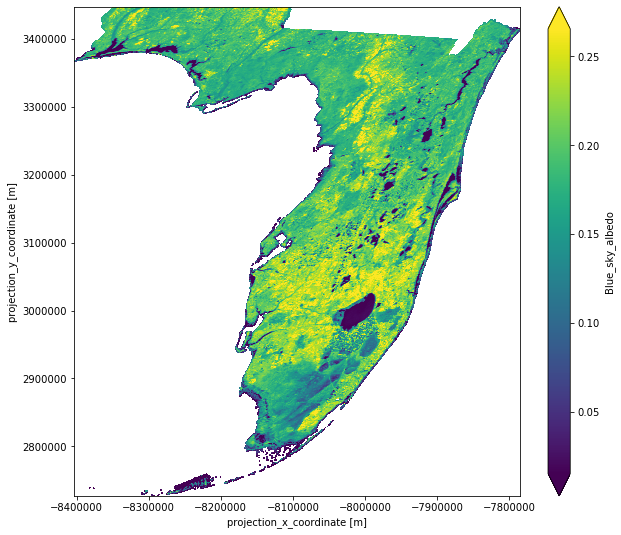

In [19]:
def alb_vectorized(wsa, bsa, lookup):
    """Vectorize albedo polynomials over two 3d arrays."""
    afunc = lambda w,b,l: (w*l)+(b*(1-l))
    return(xr.apply_ufunc(afunc, wsa, bsa, lookup))


alb = alb_vectorized(wsa, bsa, lu)
alb.name = "Blue_sky_albedo"
alb.attrs = dict(
    _FillValue=32767,
    coordinates="time y x",
    grid_mapping="crs",
    valid_min=0,
    valid_max=32766,
    long_name="Blue_sky_albedo",
    units="reflectance, no units",
    scale_factor_err=0.0,
    add_offset_err=0.0,
    calibrated_nt=5,
    scale_factor=0.001,
    add_offset=0.0)

alb.mean("time").plot.pcolormesh(
    x='x', 
    y='y',
    robust=True, 
    figsize=(10, 9),)

And that's how you calculate blue sky albedo. In the next notebook ([2_Batch_Process.ipynb](2_Batch_Process.ipynb)), define some functions that cover the steps above and calculate albedos for the remaining bands in a loop.